# Benchmark Analysis - H5

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [3]:
matplotlib.style.use('seaborn-v0_8')  

In [4]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [5]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [6]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [7]:
plot_save_dir = './plots/h5'

## Utils 

In [8]:
def get_path(*entries):
    return os.path.join(*entries)

In [9]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [10]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [11]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [12]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [13]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [14]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [15]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [16]:

def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [17]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base(bench_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H5
> Parallel stl backends use special parallelism techniques for linear algorithms, which have no clear reference
> implementation, leading to significant differences in terms of performance and their strong scaling properties.


## `b5_1_find_std::vector<int>_first_entry_par`

In [18]:
benchmark_name = "b5_1_find_std::vector<int>_first_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_first_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [19]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_first_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_first_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,7805.99,4,41628.6
1,13634.80,8,38057.3
2,19310.30,16,40446.2
3,23163.60,32,42040.3
4,27986.80,64,41732.9
5,30565.80,128,43376.3
6,32841.10,256,49596.8
7,33515.10,512,44565.0
8,33765.60,1024,51241.8
9,37787.50,2048,52718.9


### Strong Scaling - `b5_1_find_std::vector<int>_first_entry`
 
2^26 fixed input size with threads 1-64

In [20]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_first_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_first_entry_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.002467,0.000228
1,2,0.004449,0.000447
2,4,0.005891,0.000850
3,8,0.005793,0.001449
4,16,0.006092,0.002200
5,32,0.006108,0.002903
6,64,0.006021,0.003603


In [21]:
## efficiency graph

b5_1_find_std_vector_int_first_entry_efficiency = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_first_entry_efficiency['threads']



b5_1_find_std_vector_int_first_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.002467,0.000228
1,2,0.002225,0.000224
2,4,0.001473,0.000212
3,8,0.000724,0.000181
4,16,0.000381,0.000138
5,32,0.000191,0.000091
6,64,0.000094,0.000056


### Plots

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_17287/3160213828.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


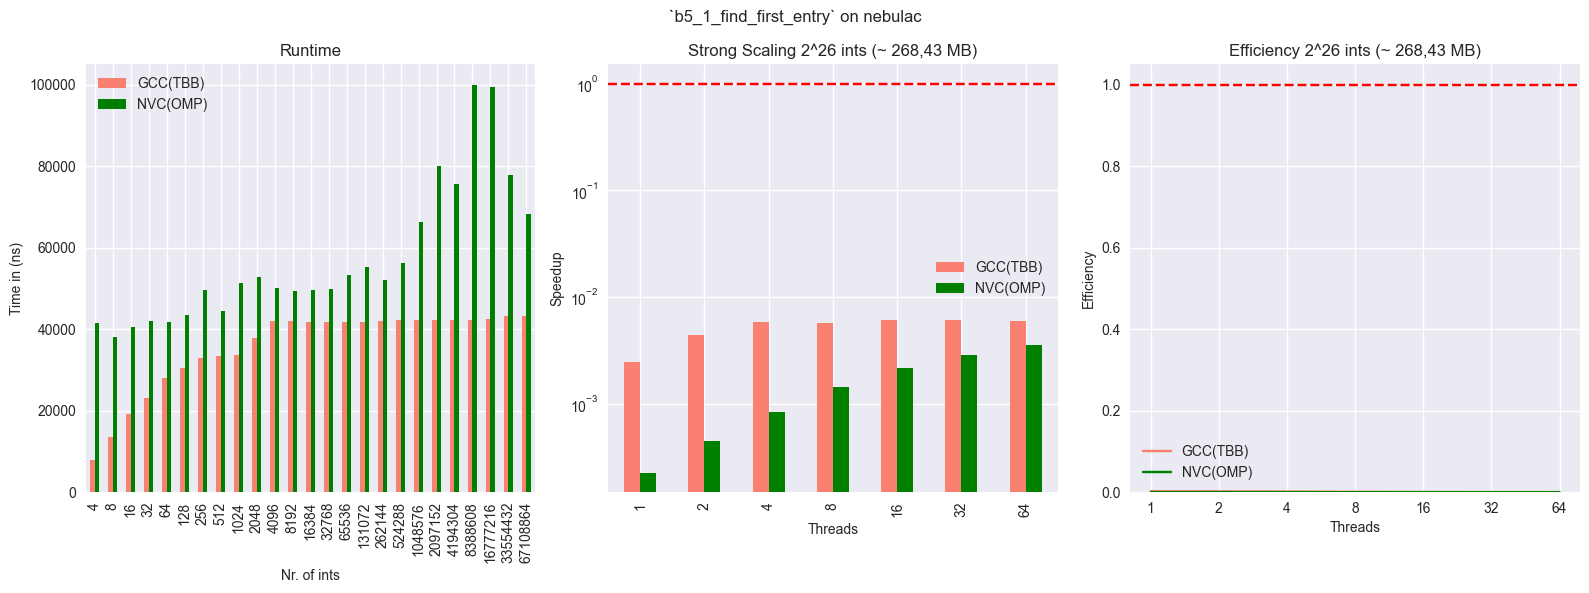

In [22]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_first_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b5_1_find_std_vector_int_first_entry_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_1_find_first_entry` on {device_name}")

fig.tight_layout()

plot(f"`b5_1_find_first_entry` {device_name}")

## `b5_1_find_std::vector<int>_last_entry_par`

In [23]:
benchmark_name = "b5_1_find_std::vector<int>_last_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_last_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [24]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_last_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_last_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,6568.93,4,46395.0
1,11180.10,8,43044.6
2,15682.40,16,43079.6
3,20285.70,32,45555.6
4,24087.70,64,44095.1
5,26433.80,128,43858.6
6,27819.90,256,44055.9
7,30630.90,512,43763.2
8,33635.60,1024,43674.1
9,37930.50,2048,43225.6


### Strong Scaling - `b5_1_find_std::vector<int>_last_entry`
 
2^26 fixed input size with threads 1-64

In [25]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_last_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_last_entry_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.997409,0.269874
1,2,1.816111,0.520929
2,4,2.379147,1.005264
3,8,1.770508,0.963649
4,16,2.095583,1.104778
5,32,2.317395,1.078152
6,64,2.192487,0.827310


In [26]:
## efficiency graph

b5_1_find_std_vector_int_last_entry_efficiency = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_last_entry_efficiency['threads']



b5_1_find_std_vector_int_last_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.997409,0.269874
1,2,0.908056,0.260465
2,4,0.594787,0.251316
3,8,0.221313,0.120456
4,16,0.130974,0.069049
5,32,0.072419,0.033692
6,64,0.034258,0.012927


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_17287/2306738438.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


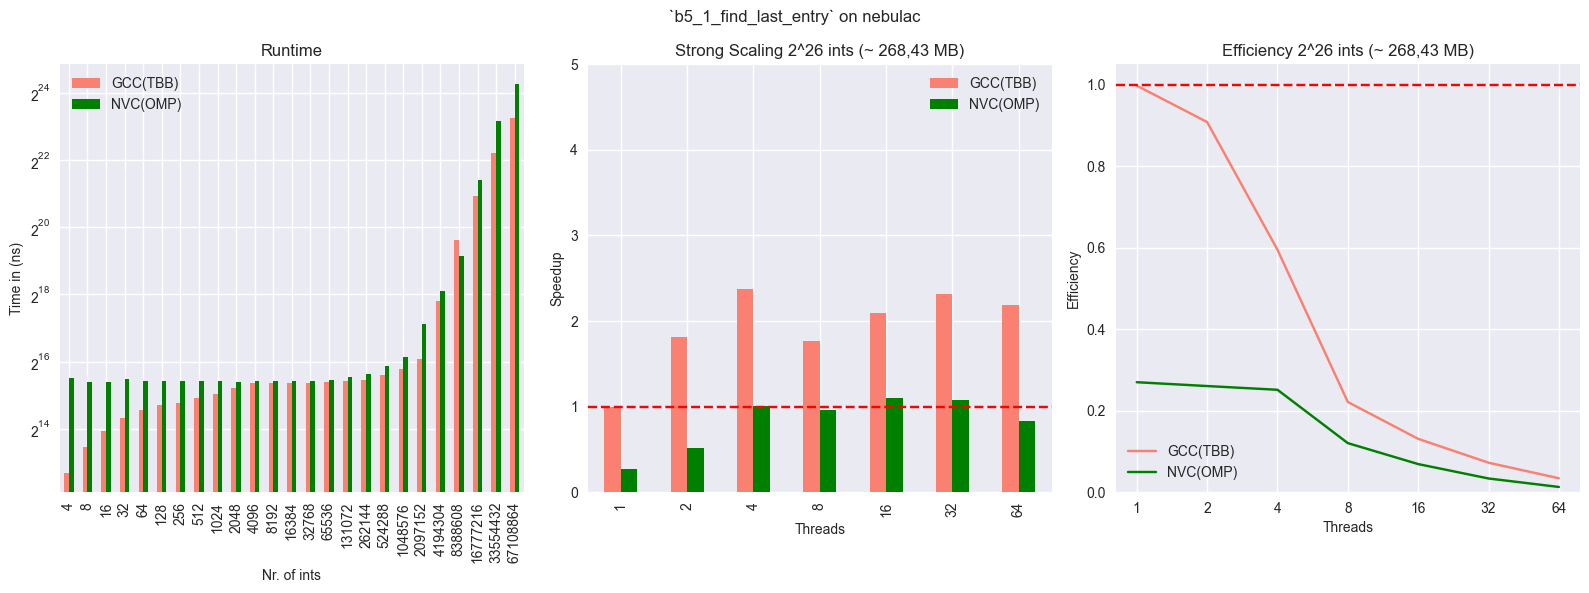

In [27]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_last_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,5)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_last_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle(f"`b5_1_find_last_entry` on {device_name}")

fig.tight_layout()

plot(f"`b5_1_find_last_entry` {device_name}")

## `b5_1_find_std::vector<int>_non_existing_entry_par`

In [28]:
benchmark_name = "b5_1_find_std::vector<int>_non_existing_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_non_existing_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [29]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_non_existing_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_non_existing_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,5740.02,4,52347.5
1,12971.40,8,40610.7
2,19567.00,16,43754.0
3,24400.20,32,42810.6
4,28192.00,64,44089.8
5,30660.00,128,43457.6
6,31581.10,256,43778.0
7,33108.30,512,43005.1
8,35293.90,1024,43031.6
9,38507.10,2048,44735.6


### Strong Scaling - `b5_1_find_std::vector<int>_non_existing_entry`
 
2^26 fixed input size with threads 1-64

In [30]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.063651,0.280556
1,2,1.656232,0.544186
2,4,2.476524,0.987441
3,8,1.570060,1.308055
4,16,1.986742,1.036792
5,32,2.115842,0.984930
6,64,1.939919,0.985252


In [31]:
## efficiency graph

b5_1_find_std_vector_int_non_existing_entry_efficiency = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_non_existing_entry_efficiency['threads']



b5_1_find_std_vector_int_non_existing_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.063651,0.280556
1,2,0.828116,0.272093
2,4,0.619131,0.246860
3,8,0.196257,0.163507
4,16,0.124171,0.064800
5,32,0.066120,0.030779
6,64,0.030311,0.015395


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_17287/1791103927.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


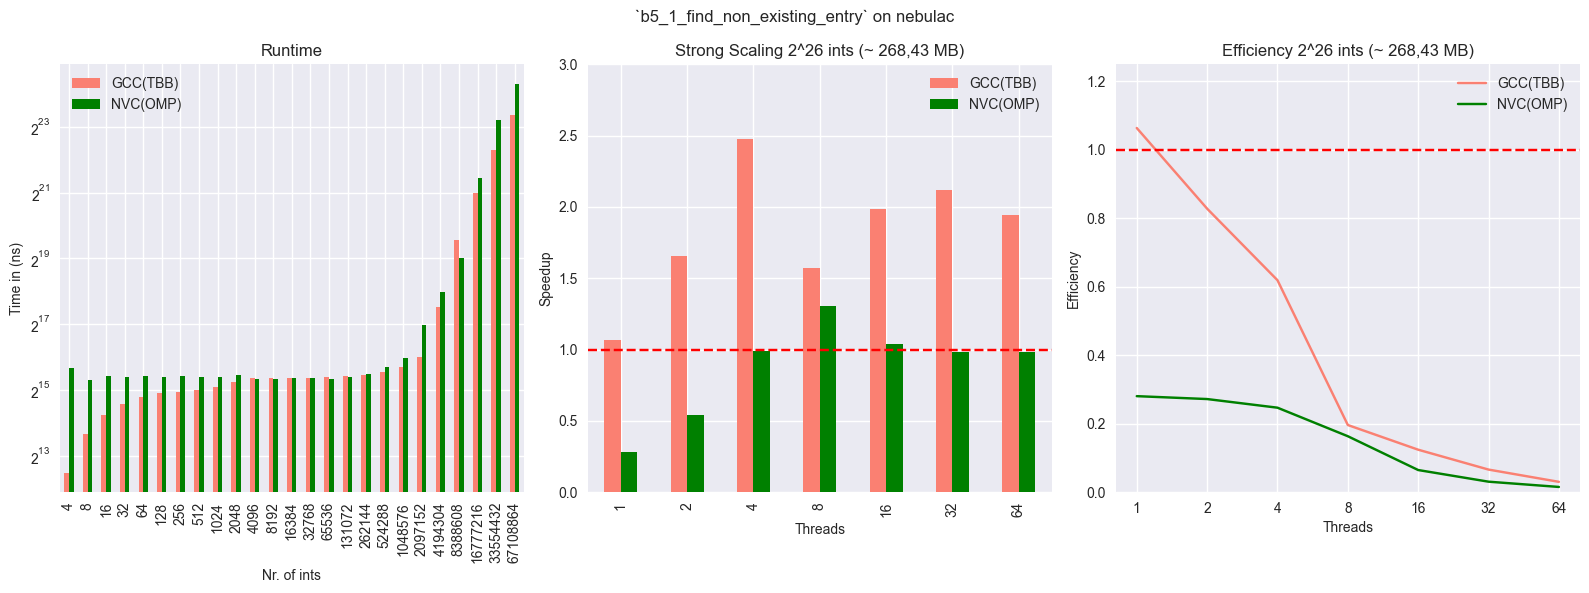

In [32]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_non_existing_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_non_existing_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle(f"`b5_1_find_non_existing_entry` on {device_name}")

fig.tight_layout()

plot(f"`b5_1_find_non_existing_entry` {device_name}")

## `b5_2_partition_par`

In [33]:
benchmark_name = "b5_2_partition"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_2_partition_par`

Check how the runtime without constraining the threads develops with increasing input size

In [34]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_2_partition_time_merged = pd.merge(*data, on='n')

b5_2_partition_time_merged

,GCC(TBB),n,NVC(OMP)
0,9185.58,4,3.514010e+02
1,16969.20,8,4.220860e+02
2,23967.70,16,5.623180e+02
3,28632.70,32,8.429090e+02
4,33336.00,64,1.404500e+03
5,34214.40,128,2.527890e+03
6,36713.00,256,4.772780e+03
7,41187.30,512,9.263100e+03
8,47307.60,1024,1.819320e+04
9,55473.10,2048,3.618090e+04


### Strong Scaling - `b5_2_partition_strong_par`
 
2^26 fixed input size with threads 1-64

In [35]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_2_partition_strong_scaling_merged = pd.merge(*data, on='threads')

b5_2_partition_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.937135,1.026821
1,2,1.876582,1.026646
2,4,3.728442,1.026786
3,8,7.128935,1.026813
4,16,14.824773,1.027023
5,32,24.872262,1.027338
6,64,49.801380,1.027031


In [36]:
## efficiency graph

b5_2_partition_efficiency = b5_2_partition_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_2_partition_efficiency[f'{compiler_name}'] = b5_2_partition_efficiency[f'{compiler_name}'] / b5_2_partition_efficiency['threads']



b5_2_partition_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.937135,1.026821
1,2,0.938291,0.513323
2,4,0.932110,0.256697
3,8,0.891117,0.128352
4,16,0.926548,0.064189
5,32,0.777258,0.032104
6,64,0.778147,0.016047


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_17287/1463862148.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


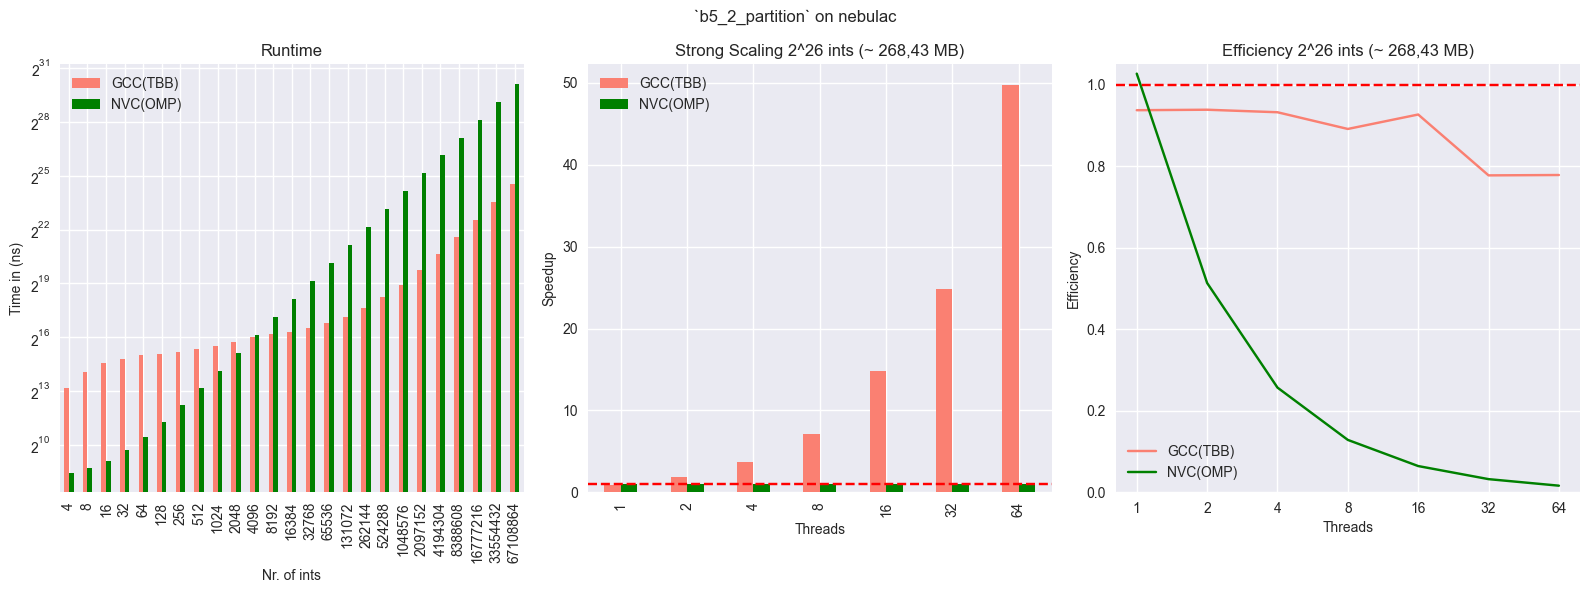

In [37]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_2_partition_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_2_partition_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_2_partition_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_2_partition` on {device_name}")

fig.tight_layout()

plot(f"`b5_2_partition` {device_name}")

## `b5_3_unique_copy_default_par`

In [38]:
benchmark_name = "b5_3_unique_copy_default"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_3_unique_copy_default_par`

Check how the runtime without constraining the threads develops with increasing input size

In [39]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_3_unique_copy_default_time_merged = pd.merge(*data, on='n')

b5_3_unique_copy_default_time_merged

,GCC(TBB),n,NVC(OMP)
0,27614.1,4,25785.4
1,48082.6,8,26174.6
2,60266.3,16,27331.3
3,72008.9,32,25730.4
4,80443.2,64,25896.7
5,83822.2,128,25545.3
6,95070.7,256,26304.7
7,89342.3,512,28315.3
8,83392.1,1024,30514.7
9,85237.5,2048,30493.0


### Strong Scaling - `b5_3_unique_copy_default_strong_par`
 
2^26 fixed input size with threads 1-64

In [40]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_3_unique_copy_default_strong_scaling_merged = pd.merge(*data, on='threads')

b5_3_unique_copy_default_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.327090,0.060008
1,2,0.593402,0.102733
2,4,1.012942,0.160072
3,8,1.278709,0.204635
4,16,1.435559,0.239581
5,32,1.514922,0.253857
6,64,1.429535,0.249042


In [41]:
## efficiency graph

b5_3_unique_copy_default_efficiency = b5_3_unique_copy_default_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_3_unique_copy_default_efficiency[f'{compiler_name}'] = b5_3_unique_copy_default_efficiency[f'{compiler_name}'] / b5_3_unique_copy_default_efficiency['threads']



b5_3_unique_copy_default_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.327090,0.060008
1,2,0.296701,0.051366
2,4,0.253236,0.040018
3,8,0.159839,0.025579
4,16,0.089722,0.014974
5,32,0.047341,0.007933
6,64,0.022336,0.003891


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_17287/1087304379.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


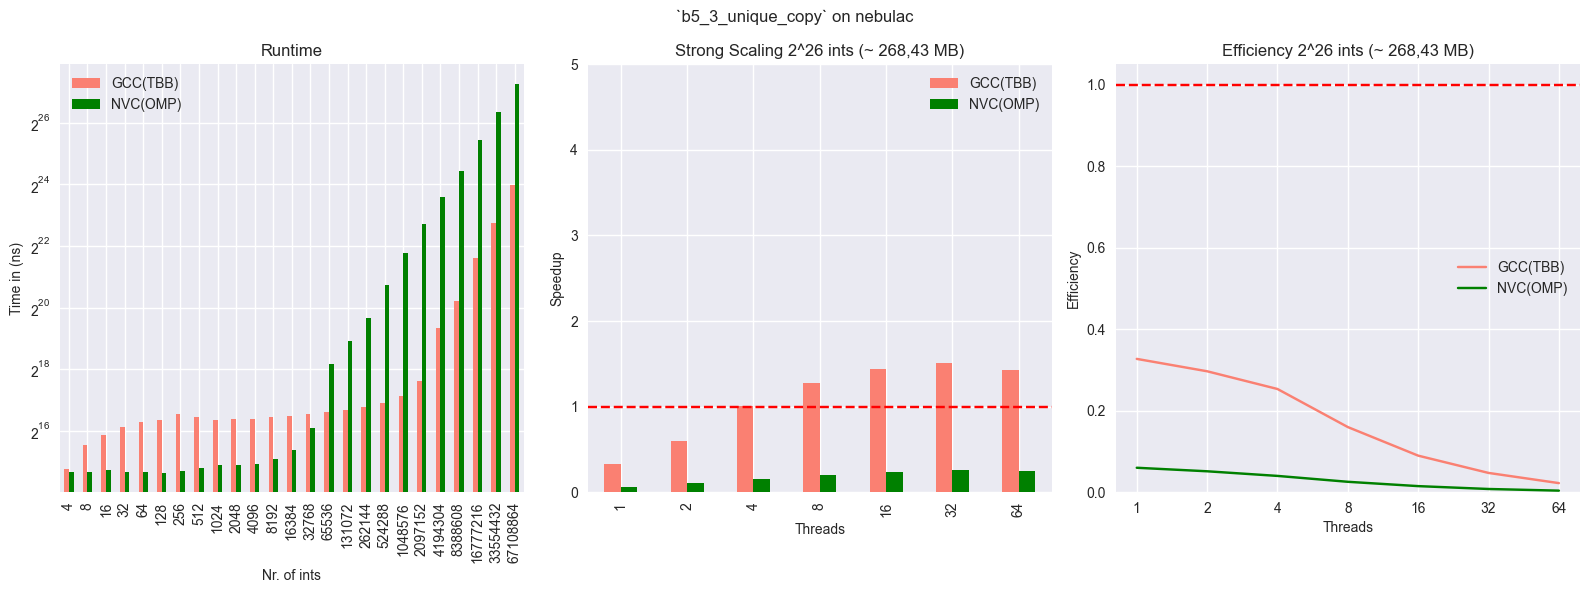

In [42]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_3_unique_copy_default_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_3_unique_copy_default_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,5)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_3_unique_copy_default_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_3_unique_copy` on {device_name}")

fig.tight_layout()

plot(f"`b5_3_unique_copy` {device_name}")

## `b5_4_minmax_element_all_equal_par`

In [43]:
benchmark_name = "b5_4_minmax_element_all_equal"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_all_equal_par`

Check how the runtime without constraining the threads develops with increasing input size

In [44]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_all_equal_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_all_equal_time_merged

,GCC(TBB),n,NVC(OMP)
0,8489.89,4,49396.0
1,15125.40,8,39142.7
2,20882.50,16,41825.0
3,24572.10,32,42974.2
4,28247.20,64,42650.3
5,32856.60,128,46421.4
6,33517.10,256,44477.2
7,36145.40,512,44943.0
8,39464.90,1024,43800.7
9,43124.80,2048,44084.7


### Strong Scaling - `b5_4_minmax_element_all_equal_strong_par`
 
2^26 fixed input size with threads 1-64

In [45]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_all_equal_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_all_equal_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.192401,0.184889
1,2,4.227877,0.369542
2,4,5.200208,0.735103
3,8,5.204363,1.456490
4,16,7.253152,2.918004
5,32,8.072857,3.222865
6,64,8.607654,4.434969


In [46]:
## efficiency graph

b5_4_minmax_element_all_equal_efficiency = b5_4_minmax_element_all_equal_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] = b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] / b5_4_minmax_element_all_equal_efficiency['threads']



b5_4_minmax_element_all_equal_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.192401,0.184889
1,2,2.113938,0.184771
2,4,1.300052,0.183776
3,8,0.650545,0.182061
4,16,0.453322,0.182375
5,32,0.252277,0.100715
6,64,0.134495,0.069296


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_17287/3056326179.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


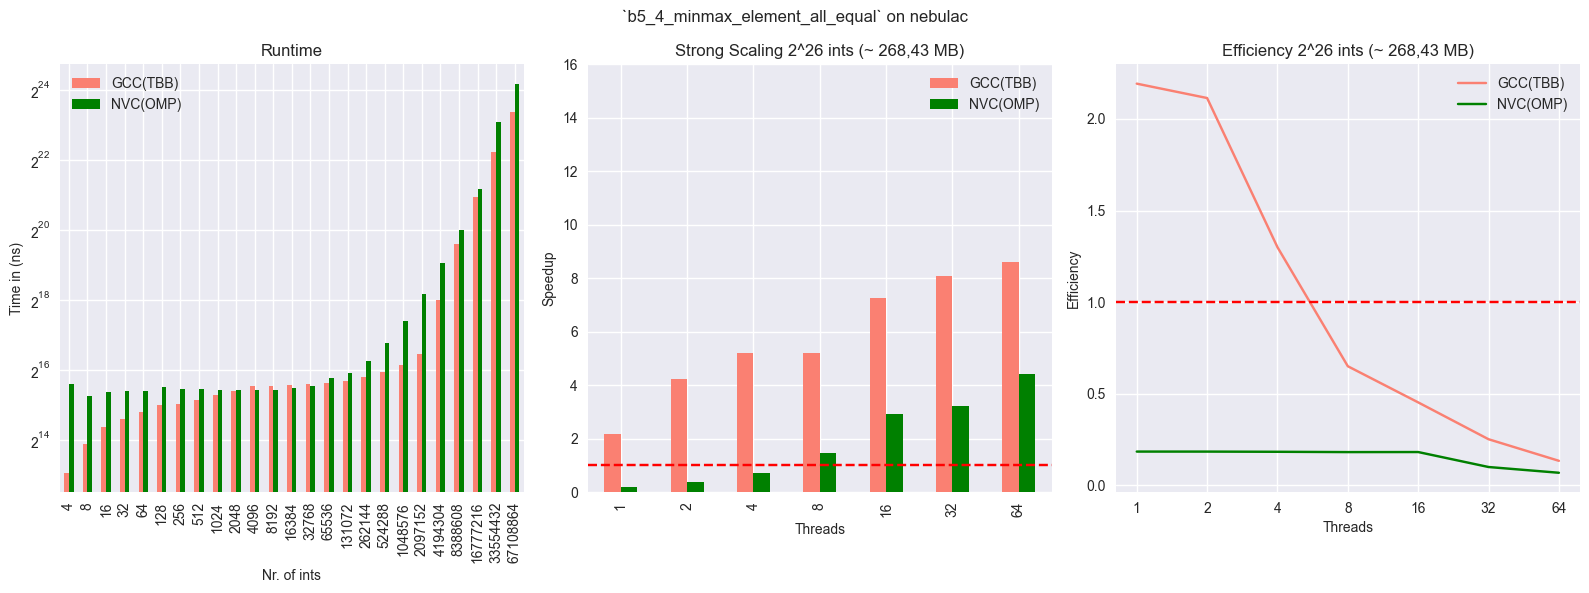

In [47]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_all_equal_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_all_equal_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')


ax_2.set_ylim(0,16)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_all_equal_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_4_minmax_element_all_equal` on {device_name}")

fig.tight_layout()

plot(f"`b5_4_minmax_element_all_equal` {device_name}")

## `b5_4_minmax_element_increasing_par`

In [48]:
benchmark_name = "b5_4_minmax_element_increasing"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_increasing_par`

Check how the runtime without constraining the threads develops with increasing input size

In [49]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_increasing_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_increasing_time_merged

,GCC(TBB),n,NVC(OMP)
0,6154.53,4,48613.5
1,11430.20,8,48275.0
2,17116.70,16,49132.2
3,22379.90,32,49155.1
4,26658.40,64,49694.2
5,28579.50,128,49697.5
6,30775.90,256,50178.4
7,33938.00,512,50704.6
8,37838.90,1024,50925.2
9,41400.10,2048,50728.5


### Strong Scaling - `b5_4_minmax_element_increasing_strong_par`
 
2^26 fixed input size with threads 1-64

In [50]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_increasing_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_increasing_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.169562,0.195137
1,2,4.114927,0.389360
2,4,8.122792,0.775784
3,8,5.953947,1.455418
4,16,7.297465,3.079760
5,32,8.194936,3.781757
6,64,7.487111,4.038378


In [51]:
## efficiency graph

b5_4_minmax_element_increasing_efficiency = b5_4_minmax_element_increasing_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] = b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] / b5_4_minmax_element_increasing_efficiency['threads']



b5_4_minmax_element_increasing_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.169562,0.195137
1,2,2.057463,0.194680
2,4,2.030698,0.193946
3,8,0.744243,0.181927
4,16,0.456092,0.192485
5,32,0.256092,0.118180
6,64,0.116986,0.063100


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_17287/771728702.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


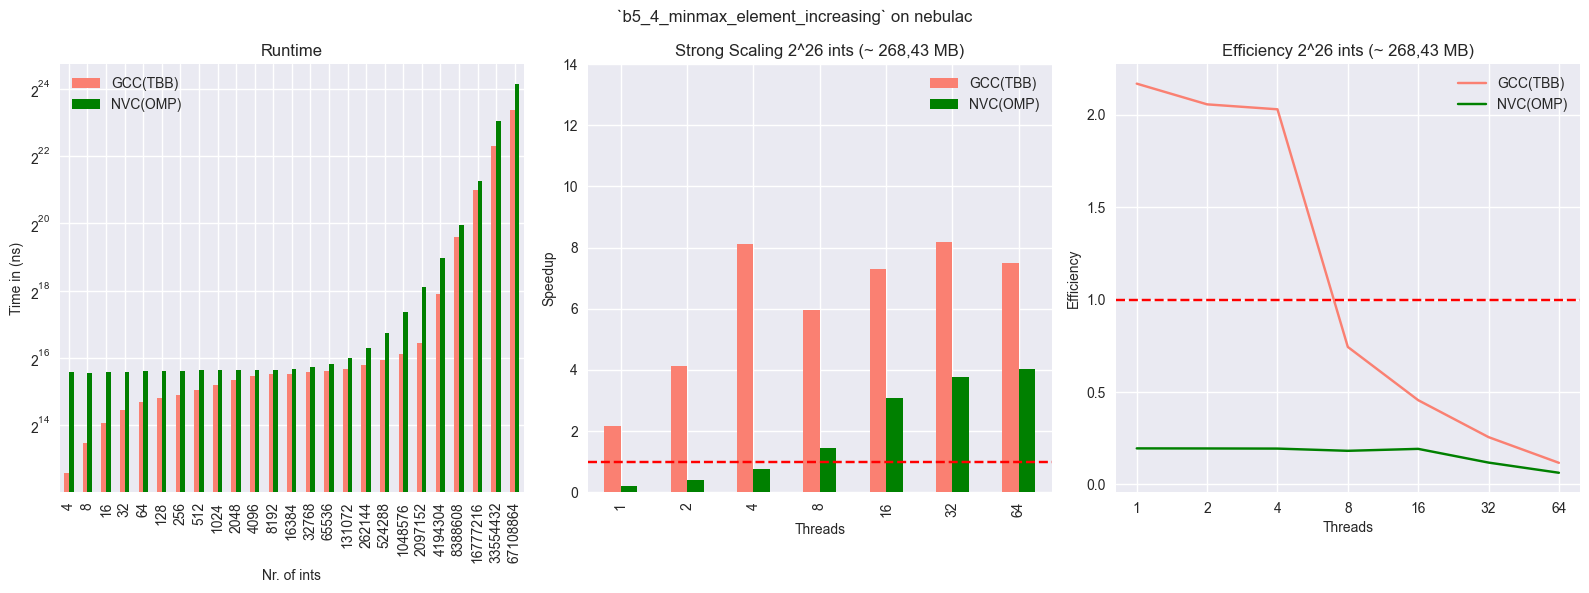

In [52]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_increasing_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_increasing_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,14)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_increasing_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b5_4_minmax_element_increasing` on {device_name}")

fig.tight_layout()

plot(f"`b5_4_minmax_element_increasing` {device_name}")

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime 

In [53]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b5_1_first_entry',b5_1_find_std_vector_int_first_entry_time_merged),
    ('b5_1_last_entry',b5_1_find_std_vector_int_last_entry_time_merged),
    ('b5_1_non_existing',b5_1_find_std_vector_int_non_existing_entry_time_merged),

    ('b5_2_partition',b5_2_partition_time_merged),

    ('b5_3_unique_copy',b5_3_unique_copy_default_time_merged),

    ('b5_4_minmax_element_all_equal',b5_4_minmax_element_all_equal_time_merged),
    ('b5_4_minmax_element_increasing',b5_4_minmax_element_increasing_time_merged),
    
]

for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df



,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,b5_1_first_entry,43327,68157,0.777277,BAD
1,b5_1_last_entry,10054300,20482600,0.658502,BAD
2,b5_1_non_existing,10822900,20800800,0.684480,BAD
3,b5_2_partition,23970800,1172650000,0.040064,BAD
4,b5_3_unique_copy,16636900,162270000,0.185984,BAD
5,b5_4_minmax_element_all_equal,10816800,19099200,0.723145,BAD
6,b5_4_minmax_element_increasing,10831900,18701800,0.733528,BAD


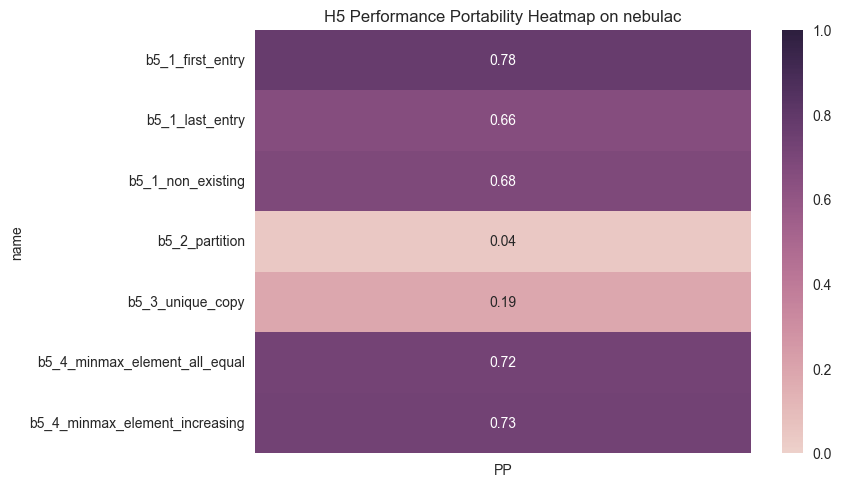

In [54]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H5 Performance Portability Heatmap on {device_name}')

plot(f'H5 Performance Portability Heatmap on {device_name}')

## Findings for H5

### XXX

### General


### GPU Findings


### Hypothesis Findings


